In [28]:
# 0. Install and Import Dependencies

# We begin by importing the necessary libraries for video processing, model building, and more.
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
from tensorflow.keras.callbacks import EarlyStopping
import gdown

# Configure TensorFlow for GPU usage
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass



In [29]:
# Download and extract the dataset
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
if not os.path.exists('data'):
    gdown.download(url, output, quiet=False)
    gdown.extractall('data.zip')


In [30]:
def load_video(path: str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        if not ret:
            break
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])  # Cropping to specific region
    cap.release()
    
    frames = np.array(frames)
    mean = np.mean(frames, axis=0)
    std = np.std(frames, axis=0)
    frames = (frames - mean) / std
    return frames


In [31]:
# Vocabulary for character mapping
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(f"The vocabulary is: {char_to_num.get_vocabulary()} (size ={char_to_num.vocabulary_size()})")


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [32]:
def load_alignments(path: str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]  # Add tokens to the list
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


In [33]:
# Function to load both video and alignment data
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    
    # Load video frames and alignment tokens
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    
    return frames, alignments


In [34]:
# Correct function for using tf.py_function
def mappable_function(path: str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75, 46, 140, 1], [None]))
data = data.prefetch(tf.data.AUTOTUNE)

# Split the dataset for training and testing
train = data.take(100)
test = data.skip(100)


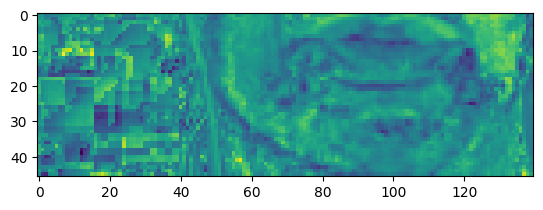

In [35]:
# Function to visualize and save frames
def save_animation(frames, filename):
    if frames.shape[-1] == 1:
        frames = np.squeeze(frames, axis=-1)
    
    # Convert frames to uint8 format (for GIF saving) if they're not already
    frames_uint8 = frames.astype(np.uint8)
    
    # Save as GIF using imageio
    imageio.mimsave(filename, frames_uint8, fps=10)  # Save frames as an animated GIF

# Get frames and alignments from the dataset
sample = data.as_numpy_iterator().next()

# Unpack the sample correctly
frames, alignments = sample

# Save the first set of frames (frames[0]) as an animated GIF
save_animation(frames[0], './animation.gif')
plt.imshow(frames[0][35])  # Visualize the 35th frame of the first video in the batch
plt.show()


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

# Create the LipNet model
model = Sequential()

model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_6 (Conv3D)               │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [38]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


In [39]:
# Custom callback to produce examples at the end of each epoch
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        frames = data[0]
        yhat = self.model.predict(frames)
        batch_size = len(yhat)
        sequence_lengths = [frames.shape[1]] * batch_size
        
        print("Batch size:", batch_size)
        print("Sequence lengths:", sequence_lengths)
        
        decoded = tf.keras.backend.ctc_decode(yhat, sequence_lengths, greedy=False)[0][0].numpy()
        for x in range(batch_size):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~' * 100)


In [42]:
# Compile the model with an Adam optimizer and CTC los
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

# Define a checkpoint callback to save only model weights
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint.weights.h5'), 
                                      monitor='loss', 
                                      save_weights_only=True)

# Define learning rate scheduler callback
schedule_callback = LearningRateScheduler(scheduler)

# Define the example callback (custom callback)
example_callback = ProduceExample(test)

# Split the dataset
train = data.take(100)  # Take the first 100 samples for training
test = data.skip(100).take(20)  # Use the next 20 samples for testing

# Train the model for a minimum number of epochs (e.g., 10)
model.fit(train, validation_data=test, epochs=10, 
          callbacks=[checkpoint_callback, schedule_callback, example_callback], 
          batch_size=16)  # Small batch size to fit in RTX 3050 memory


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/stepstep - loss: 67.273
Batch size: 2
Sequence lengths: [75, 75]
Original: set blue at g eight now
Prediction: la 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green with d zero now
Prediction: la 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
100/100 ━━━━━━━━━━━━━━━━━━━━ 1050s 10s/step - loss: 67.2742 - val_loss: 64.9580 - learning_rate: 1.0000e-04
Epoch 2/10
 45/100 ━━━━━━━━━━━━━━━━━━━━ 6:51 7s/step - loss: 66.0347

KeyboardInterrupt: 

In [27]:
# Make a Prediction
sample_video = load_data(tf.convert_to_tensor('.\\data\\s1\\sbia2p.mpg'))

print('REAL TEXT','~' * 100)
print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample_video[1]]])

yhat = model.predict(tf.expand_dims(sample_video[0], axis=0))
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

print('PREDICTIONS','~' * 100, )
print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded])


REAL TEXT ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[<tf.Tensor: shape=(), dtype=string, numpy=b'set blue in a two please'>]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
PREDICTIONS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[<tf.Tensor: shape=(), dtype=string, numpy=b''>]
